# Exercise 2
## 3 Data Preparation

In [683]:
#import libraries used for the exercises
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from scipy.stats import multivariate_normal

digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

#apply a filter such that only "1" and "7" are left
cond = np.logical_or(target==1, target==7)

data_filtered         = data[cond]
images_filtered       = images[cond]
target_filtered       = target[cond]
target_names_filtered = np.array([1,7])

data_test   = data_filtered[:int(len(data_filtered)*2/5)]
target_test = target_filtered[:int(len(data_filtered)*2/5)]
 
data_train = data_filtered[int(len(data_filtered)*2/5):]
target_train = target_filtered[int(len(data_filtered)*2/5):]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


### 3.1 Dimension Reduction
To find out which pixels/features are suitable to distuingish between 1 and 7, we take a look at the "average 7" and "average 1" as well as the corresponding variances.

Text(0, 0.5, 'y')

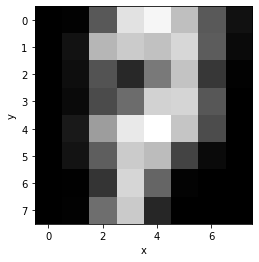

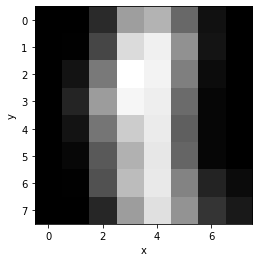

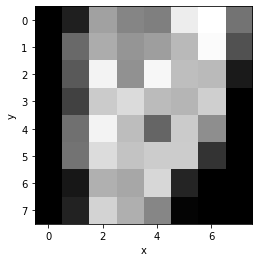

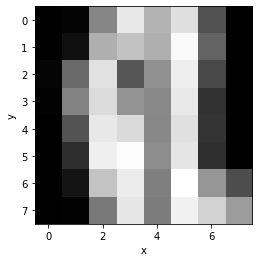

In [684]:
avg7 = np.mean(images_filtered[target_filtered==7], axis=0)
avg1 = np.mean(images_filtered[target_filtered==1], axis=0)
std7 = np.std(images_filtered[target_filtered==7], axis=0)
std1 = np.std(images_filtered[target_filtered==1], axis=0)

plt.figure()
plt.imshow(avg7, cmap="gray")
plt.xlabel("x")
plt.ylabel("y")
plt.figure()
plt.imshow(avg1, cmap="gray")
plt.xlabel("x")
plt.ylabel("y")
plt.figure()
plt.imshow(std7, cmap="gray")
plt.xlabel("x")
plt.ylabel("y")
plt.figure()
plt.imshow(std1, cmap="gray")
plt.xlabel("x")
plt.ylabel("y")

We can easily see that the pixels with the coordinates (x,y)=(3,2) and (x,y)=(4,7) are very bright for the average 1 while they are dark for the average 7. Furthermore, the variance of these pixels is relatively small in most of the cases. So we choose these two pixels as our features for the rest of this exercise. When you flatten the arrays corresponding to the images in the order [first row, second row,...,eighth row] the two pixels have the indices 19 and 61.

In [685]:
#Now we define a function that does the dimension reduction
def reduce_dim(x):
    output = []
    for i in range(len(x)):
        output.append([x[i][19], x[i][60]])
    return np.array(output)

#reduce the dimension of the (test and training) data sets
data_r       = reduce_dim(data_filtered)
data_train_r = reduce_dim(data_train)
data_test_r  = reduce_dim(data_test)

### 3.2 Scatterplot

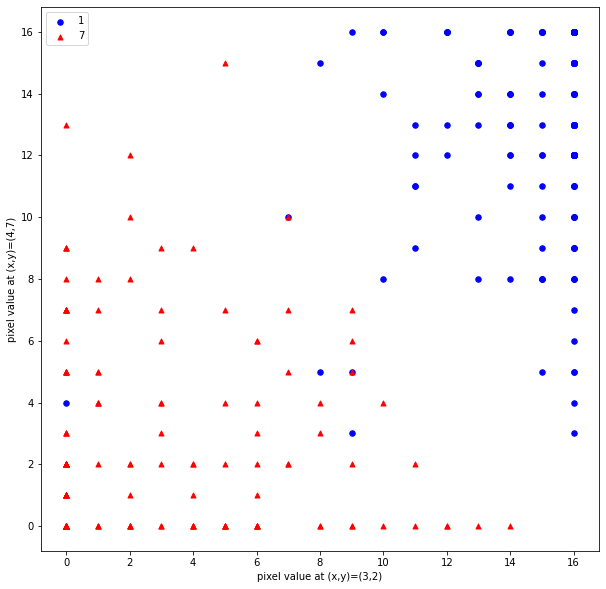

In [686]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

xvals = data_r[target_filtered==1].transpose()[0]
yvals = data_r[target_filtered==1].transpose()[1]
ax.scatter(xvals, yvals, label="1", color="blue", s=30) #plot 1s

xvals = data_r[target_filtered==7].transpose()[0]
yvals = data_r[target_filtered==7].transpose()[1]
ax.scatter(xvals, yvals, label="7", color="red", s=25, marker="^") #plot 7s

ax.set_xlabel("pixel value at (x,y)=(3,2)")
ax.set_ylabel("pixel value at (x,y)=(4,7)")
ax.legend()
plt.show()

We see that the 7s concentrate in the lower left corner while the 1s mostly sit in the upper right corner. However, there is a small overlap of the two distributions.

## 4 Nearest Mean
### 4.1 Implement nearest mean classifier

In [687]:
#function for distance computation from exercise 1b
def dist_vec(training, test):
    #test if the inputs are NxD, MxD matrices
    assert (2 == len(np.shape(training))), "training does not have a valid shape."
    assert (2 == len(np.shape(test))), "training does not have a valid shape."
    assert (np.shape(test)[1] == np.shape(training)[1]), "training and test do not have compatible shapes."   
    
    #convert trianing and test to numpy arrays
    training = np.array(training)
    test = np.array(test)
    
    distances = np.linalg.norm(training[:, np.newaxis]-test, axis=2)

    return distances

#implementation of the nearest mean classifier
def nearest_mean(training_features, training_labels, test_features):
    means   = np.empty((0,len(training_features[0])))
    labels = np.unique(training_labels)
    
    #compute mean for each class
    for c in labels:
        mean = np.mean(training_features[training_labels==c], axis=0)
        means = np.append(means, [mean], axis=0)
    
    #compute the label for each value in test_features
    distances = dist_vec(means, test_features)
    nearest_mean_labels = np.argmin(distances, axis=0)
    return labels[nearest_mean_labels]

### 4.2 Visualize the decision regions
The chosen features are two pixel values. These are between 0 and 16. The grid used for visualizing the the decision rule should therefore cover this range.

In [688]:
#create grid for decision rule
x = np.linspace(0,16,200,endpoint=True)
grid = np.transpose([np.tile(x, len(x)), np.repeat(np.flip(x), len(x))])
labels = nearest_mean(data_train_r, target_train, grid)
labels = np.reshape(labels, (200, 200))

Text(0.5, 1.0, 'decision rule of our nearest mean classifier \n (red ~ 7, blue ~ 1)')

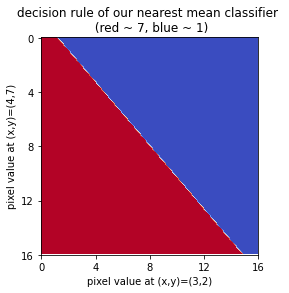

In [689]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(labels, cmap="coolwarm")
ax.set_xlabel("pixel value at (x,y)=(3,2)")
ax.set_ylabel("pixel value at (x,y)=(4,7)")
ax.set_xticks([0,50,100,150,200])
ax.set_xticklabels(["0","4","8","12","16"])
ax.set_yticks([0,50,100,150,200])
ax.set_yticklabels(["0","4","8","12","16"])
ax.set_title("decision rule of our nearest mean classifier \n (red ~ 7, blue ~ 1)")

## 5 QDA
### 5.1 Implement QDA Training

In [690]:
def fit_qda(training_features, training_labels):
    #compute the priors p
    p0 = len(training_labels[training_labels==0])/len(training_labels)
    p = np.stack((p0, 1-p0))
    
    #compute mu
    features0 = training_features[training_labels==0]
    features1 = training_features[training_labels==1]
    mu = np.stack((np.mean(features0, axis=0), np.mean(features1, axis=0)))
    
    #compute the covariance matrix
    covmat0 = np.cov(features0.transpose())
    covmat1 = np.cov(features1.transpose())
    covmat = np.stack((covmat0, covmat1))
    
    return [mu, covmat, p]

In [691]:
#map the label 1 to 0 and 7 to 1
target_train_qda = target_train.copy() 
target_train_qda[target_train_qda==1] = 0
target_train_qda[target_train_qda==7] = 1

#apply fit_qda to the data from 3.1
mu, covmat, p = fit_qda(data_train_r, target_train_qda)

### 5.2 Implement QDA Prediction

In [692]:
def predict_qda(mu, covmat, p, test_features):
    mu0 = mu[0,:]
    mu1 = mu[1,:]
    
    K0 = np.linalg.inv(covmat[0])
    K1 = np.linalg.inv(covmat[1])
    
    z0 = test_features - mu0
    z1 = test_features - mu1
    
    p0 = p[0] * np.exp(-0.5*np.sum(z0 * (K0 @ z0.transpose()).transpose(), axis=1)) / np.linalg.det(covmat[0] * 2 * np.pi)
    p1 = p[1] * np.exp(-0.5*np.sum(z1 * (K1 @ z1.transpose()).transpose(), axis=1)) / np.linalg.det(covmat[1] * 2 * np.pi)
    
    return np.array(p0<p1, dtype=int)

In [693]:
#apply to training data
labels = predict_qda(mu, covmat, p, data_train_r)
error_rate = 1 - np.sum(labels==target_train_qda)/len(labels)
print("training set:")
print("error rate:",np.round(error_rate*100,3), "%")

training set:
error rate: 0.922 %


In [694]:
#ma_p the label 1 to 0 and 7 to 1
target_test_qda = target_test.copy() 
target_test_qda[target_test_qda==1] = 0
target_test_qda[target_test_qda==7] = 1

#apply to test data
labels = predict_qda(mu, covmat, p, data_test_r)
error_rate = 1 - np.sum(labels==target_test_qda)/len(labels)
print("applied to test set:")
print("error rate:",np.round(error_rate*100,3), "%")

applied to test set:
error rate: 3.472 %


### 5.3 Visualization

In [695]:
#create grid for decision rule
x = np.linspace(0,16,200,endpoint=True)
grid = np.transpose([np.tile(x, len(x)), np.repeat(np.flip(x), len(x))])
labels_grid = predict_qda(mu, covmat, p, grid)
labels_grid = np.reshape(labels_grid, (200, 200))

#overlay of the training set
labels_train = predict_qda(mu, covmat, p, data_train_r)
train0 = data_train_r[labels_train==0]
train1 = data_train_r[labels_train==1]

#overlay of the gaussian distributions
gauss0 = multivariate_normal(mu[0], covmat[0])
gauss1 = multivariate_normal(mu[1], covmat[1])
x = np.linspace(0,16,200,endpoint=True)
X, Y = np.meshgrid(x,x)
density0 = gauss0.pdf(np.dstack((X,Y)))
density1 = gauss1.pdf(np.dstack((X,Y)))

#eigenvalue decomposition
w,v = np.linalg.eig(covmat[0])
vec1 = v[:,0] * np.sqrt(w[0])
vec2 = v[:,1] * np.sqrt(w[1])

w,v = np.linalg.eig(covmat[1])
vec3 = v[:,0] * np.sqrt(w[0])
vec4 = v[:,1] * np.sqrt(w[1])


Text(0.5, 1.0, 'decision rule of our nearest mean classifier \n (red ~ 7, blue ~ 1)')

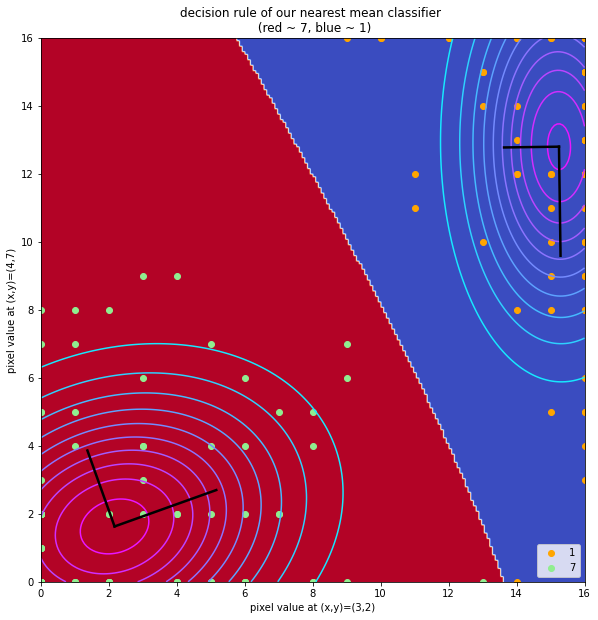

In [696]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ax.imshow(labels_grid, cmap="coolwarm", extent=(0,16,0,16)) #decision regions

x, y = train0.transpose() #overlay of label 1 training data
ax.scatter(x,y, color="orange", label="1")
x, y = train1.transpose() #overlay of label 7 training data
ax.scatter(x,y, color="lightgreen", label="7") 

ax.contour(X, Y, density0, cmap="cool", levels=10) #overlay of label 1 gaussian
ax.contour(X, Y, density1, cmap="cool", levels=10) #overlay of label 7 gaussian

#overlay of eigenvectors of covariance matrices
ax.plot([mu[0][0], vec1[0]+mu[0][0]], [mu[0][1], vec1[1]+mu[0][1]], linewidth=2.5, color="black")
ax.plot([mu[0][0], vec2[0]+mu[0][0]], [mu[0][1], vec2[1]+mu[0][1]], linewidth=2.5, color="black")
ax.plot([mu[1][0], vec3[0]+mu[1][0]], [mu[1][1], vec3[1]+mu[1][1]], linewidth=2.5, color="black")
ax.plot([mu[1][0], vec4[0]+mu[1][0]], [mu[1][1], vec4[1]+mu[1][1]], linewidth=2.5, color="black")

ax.set_xlabel("pixel value at (x,y)=(3,2)")
ax.set_ylabel("pixel value at (x,y)=(4,7)")
ax.legend(loc="lower right")
ax.set_title("decision rule of our nearest mean classifier \n (red ~ 7, blue ~ 1)")

[1.08569836e-21 1.73177230e-21 2.75548404e-21 ... 1.03066949e-05
 1.01506039e-05 9.97217389e-06]
[[ 0.         16.        ]
 [ 0.08040201 16.        ]
 [ 0.16080402 16.        ]
 ...
 [15.83919598  0.        ]
 [15.91959799  0.        ]
 [16.          0.        ]]


### 5.4 Performance evalutation

In [697]:
#TODO

## 6 LDA
### 6.1 Implement LDA training

In [698]:
def fit_lda(training_features, training_labels):
    #compute the priors p
    p0 = len(training_labels[training_labels==0])/len(training_labels)
    p = np.stack((p0, 1-p0))
    
    #compute mu
    features0 = training_features[training_labels==0]
    features1 = training_features[training_labels==1]
    mu = np.stack((np.mean(features0, axis=0), np.mean(features1, axis=0)))
    
    #compute the covariance matrix
    covmat = (np.cov(features0.transpose()) + np.cov(features1.transpose()))/2
        
    return mu, covmat, p

In [699]:
#map the label 1 to 0 and 7 to 1
target_train_lda = target_train.copy() 
target_train_lda[target_train_lda==1] = 0
target_train_lda[target_train_lda==7] = 1

#apply fit_lda to the data from 3.1
mu, covmat, p = fit_lda(data_train_r, target_train_lda)

### 6.2 Implement LDA Prediction

In [700]:
def predict_lda(mu, covmat, p, test_features):
    mu0 = mu[0,:]
    mu1 = mu[1,:]
    
    K = np.linalg.inv(covmat)
    
    z0 = test_features - mu0
    z1 = test_features - mu1
        
    p0 = p[0] * np.exp(-0.5*np.sum(z0 * (K @ z0.transpose()).transpose(), axis=1)) / np.linalg.det(covmat * 2 * np.pi)
    p1 = p[1] * np.exp(-0.5*np.sum(z1 * (K @ z1.transpose()).transpose(), axis=1)) / np.linalg.det(covmat * 2 * np.pi)
    
    return np.array(p0<p1, dtype=int)

In [701]:
#apply to training data
labels = predict_lda(mu, covmat, p, data_train_r)
error_rate = 1 - np.sum(labels==target_train_lda)/len(labels)
print("training set:")
print("error rate:",np.round(error_rate*100,3), "%")

training set:
error rate: 1.382 %


In [702]:
#ma_p the label 1 to 0 and 7 to 1
target_test_lda = target_test.copy() 
target_test_lda[target_test_lda==1] = 0
target_test_lda[target_test_lda==7] = 1

#apply to test data
labels = predict_lda(mu, covmat, p, data_test_r)
error_rate = 1 - np.sum(labels==target_test_lda)/len(labels)
print("applied to test set:")
print("error rate:",np.round(error_rate*100,3), "%")

applied to test set:
error rate: 3.472 %


### 6.3 Visualization

In [703]:
#create grid for decision rule
x = np.linspace(0,16,200,endpoint=True)
grid = np.transpose([np.tile(x, len(x)), np.repeat(np.flip(x), len(x))])
labels_grid = predict_lda(mu, covmat, p, grid)
labels_grid = np.reshape(labels_grid, (200, 200))

#overlay of the training set
labels_train = predict_lda(mu, covmat, p, data_train_r)
train0 = data_train_r[labels_train==0]
train1 = data_train_r[labels_train==1]

#overlay of the gaussian distributions
gauss0 = multivariate_normal(mu[0], covmat)
gauss1 = multivariate_normal(mu[1], covmat)
x = np.linspace(0,16,200,endpoint=True)
X, Y = np.meshgrid(x,x)
density0 = gauss0.pdf(np.dstack((X,Y)))
density1 = gauss1.pdf(np.dstack((X,Y)))

#eigenvalue decomposition
w,v = np.linalg.eig(covmat)
vec1 = v[:,0] * np.sqrt(w[0])
vec2 = v[:,1] * np.sqrt(w[1])

Text(0.5, 1.0, 'decision rule of our nearest mean classifier \n (red ~ 7, blue ~ 1)')

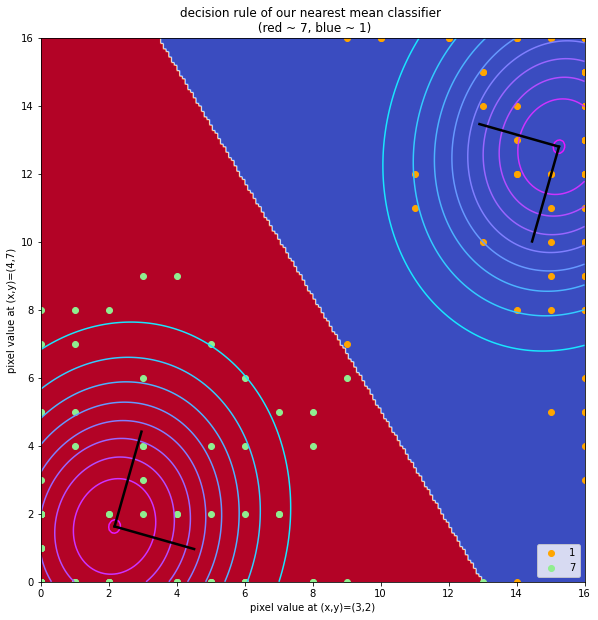

In [704]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ax.imshow(labels_grid, cmap="coolwarm", extent=(0,16,0,16)) #decision regions

x, y = train0.transpose() #overlay of label 1 training data
ax.scatter(x,y, color="orange", label="1")
x, y = train1.transpose() #overlay of label 7 training data
ax.scatter(x,y, color="lightgreen", label="7") 

ax.contour(X, Y, density0, cmap="cool", levels=10) #overlay of label 1 gaussian
ax.contour(X, Y, density1, cmap="cool", levels=10) #overlay of label 7 gaussian

#overlay of eigenvectors of covariance matrices
ax.plot([mu[0][0], vec1[0]+mu[0][0]], [mu[0][1], vec1[1]+mu[0][1]], linewidth=2.5, color="black")
ax.plot([mu[0][0], vec2[0]+mu[0][0]], [mu[0][1], vec2[1]+mu[0][1]], linewidth=2.5, color="black")
ax.plot([mu[1][0], -vec1[0]+mu[1][0]], [mu[1][1], -vec1[1]+mu[1][1]], linewidth=2.5, color="black")
ax.plot([mu[1][0], -vec2[0]+mu[1][0]], [mu[1][1], -vec2[1]+mu[1][1]], linewidth=2.5, color="black")

ax.set_xlabel("pixel value at (x,y)=(3,2)")
ax.set_ylabel("pixel value at (x,y)=(4,7)")
ax.legend(loc="lower right")
ax.set_title("decision rule of our nearest mean classifier \n (red ~ 7, blue ~ 1)")

### 6.4 Performance evaluation

In [ ]:
#TODO